In [987]:
from sklearn import metrics
import os
import sys
#os.environ["CUDA_VISIBLE_DEVICES"]="7"

from pandas import DataFrame
from IPython.display import HTML


import numpy as np
import pandas as pd
get_ipython().config.get('IPKernelApp', {})['parent_appname'] = ""
np.random.seed(12345)
import matplotlib.pyplot as plt
%matplotlib inline

from fastai.basic_data import *
from fastai.basic_train import *
from fastai.data_block import *
from fastai.metrics import *
from fastai.train import *
from fastai.utils import *
from fastai.core import *
from fastai.gen_doc import *

#from fastai import Learner,DataBunch

import torch
import torch.nn as nn
import torch.utils.data as tdatautils

import glob
import re


In [988]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import average_precision_score
from sklearn import random_projection
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import MinMaxScaler

### Data loader
- X shape (complexes, amino positions, features) = (1464, 455, 9)
- Vector of complexes
- Vector of amino acids
- Dstack features with residues

In [989]:
!du -h /scratch/maghoi/pMHC_data/features6/

298M	/scratch/maghoi/pMHC_data/features6/


### Load data

In [990]:
filelist_loaded = []
filelist = glob.glob("/scratch/maghoi/pMHC_data/features5/*.csv"); len(filelist)
for i in range(0, len(filelist)):
    df = pd.read_csv(filelist[i])
    #df = df.drop(["Unnamed: 0", "Num", "pACC", "CNb"], axis = 1)

    #Convert categorical values (res + solvent acc cateogry) to string
    #df.iloc[:, 0:2] = df.iloc[:, 0:2].astype(int).astype(str)
    filelist_loaded.append(df)

In [991]:
filelist_loaded[1463]

1mwa_1p_N3_1t_95s_pMHC-TCR Sequence SSE CLE  ACC  pACC  CNa  CNb  Type
0                             0        G   L   R    2    95    2    2     1
1                             1        P   L   R    2    56    4    5     1
2                             2        H   E   E    1    34    6    7     1
3                             3        S   E   F    0    10    9    9     1
4                             4        L   E   D    0     0   11    9     1
5                             5        R   E   E    1    18    8    7     1
6                             6        Y   E   E    0     0    9   10     1
7                             7        F   E   E    1    33    8    8     1
8                             8        V   E   E    0     2    8   12     1
9                             9        T   E   E    1    13    8    7     1
10                           10        A   E   E    0     3   10   11     1
11                           11        V   E   E    1    28    7    6     1
12                           12        S   E   C    1    16    8    7     1
13                           13        R   E   E    1    33    7    5     1
14                           14        P   T   E    1    39    5    4     1
15                           15        G   T   N    2   100    0    0     1
16                           16        L   T   M    2    71    0    0     1
17                           17        G   E   L    2    62    1    1     1
18                           18        E   E   Q    2    54    2    3     1
19                           19        P   E   C    1    19    6    8     1
20                           20        R   E   C    1    27    8    7     1
21                           21        Y   E   E    0     1    9   11     1
22                           22        M   E   E    1    18    7    8     1
23                           23        E   E   E    0     0    8   10     1
24                           24        V   E   E    0     5    8    8     1
25                           25        G   E   E    0     0    9   10     1
26                           26        Y   E   E    1    25    9    8     1
27                           27        V   E   E    0     0    9   10     1
28                           28        D   T   N    1    35    4    3     1
29                           29        D   T   O    2    71    3    2     1
..                          ...      ...  ..  ..  ...   ...  ...  ...   ...
438                         438        G   T   N    0     4    7    8     4
439                         439        T   E   G    1    24    3    6     4
440                         440       -1  -1  -1   -1    -1   -1   -1     4
441                         441       -1  -1  -1   -1    -1   -1   -1     4
442                         442       -1  -1  -1   -1    -1   -1   -1     4
443                         443       -1  -1  -1   -1    -1   -1   -1     4
444                         444       -1  -1  -1   -1    -1   -1   -1     4
445                         445       -1  -1  -1   -1    -1   -1   -1     4
446                         446       -1  -1  -1   -1    -1   -1   -1     4
447                         447       -1  -1  -1   -1    -1   -1   -1     4
448                         448       -1  -1  -1   -1    -1   -1   -1     4
449                         449       -1  -1  -1   -1    -1   -1   -1     4
450                         450       -1  -1  -1   -1    -1   -1   -1     4
451                         451       -1  -1  -1   -1    -1   -1   -1     4
452                         452       -1  -1  -1   -1    -1   -1   -1     4
453                         453       -1  -1  -1   -1    -1   -1   -1     4
454                         454       -1  -1  -1   -1    -1   -1   -1     4
455                         455       -1  -1  -1   -1    -1   -1   -1     4
456                         456        L   E   E    0     5    5   11     4
457                         457        Y   E   E    2    50    5    7     4
458                         458        F   E   F    0

### Load prepared .npy files

In [992]:
ix_train = 1080
ix_val = 256
ix_test = 128
data_size=1464

ix_test = data_size - ix_test
ix_val = ix_test - ix_val
ix_train = ix_val - ix_train

print(data_size)
print(ix_test)
print(ix_val)
print(ix_train)

1464
1336
1080
0


In [993]:
np.load("/scratch/maghoi/pMHC_data/features6/2f53_2p_S1_1t_80s_pMHC-TCR.npy").shape[1]

56

In [994]:
len(range(0, 1464))

1464

In [995]:
### Start position 0
def data_generator(ix_train = 1080, ix_val = 256, ix_test = 128, data_size=1464):
        filelist = glob.glob("/scratch/maghoi/pMHC_data/features6/*.npy"); len(filelist)
        
        filelist_loaded = []
        ix_test = data_size - ix_test
        ix_val = ix_test - ix_val
        ix_train = ix_val - ix_train
        
        #Load data into dfs
        for i in range(0, len(filelist)):
            df = np.load(filelist[i])
            filelist_loaded.append(df)

        #Initialize empty df ordered by complexes and aminos
        dim1 = range(0, data_size)
        dim2 = filelist_loaded[0].shape[0]
        dim3 = filelist_loaded[0].shape[1]
        x = np.zeros(shape = (data_size, dim2, dim3))

        for i in range(0, data_size):
            x[i] = filelist_loaded[i]

        #Extract y
        y = np.zeros(shape = (data_size), dtype="int64")

        counter_x = range(0, data_size)
        counter_y = range(len(y))
        for c_x, c_y in zip(counter_x, counter_y):
            r = re.compile(r'.*P1.*')
            if bool(r.match(filelist[c_x])):
                y[c_y] = 1
                
        X_train, y_train = x[0 : ix_val], y[0 : ix_val]
        X_val, y_val = x[ix_val : ix_test], y[ix_val : ix_test]
        X_test, y_test = x[ix_test : ], y[ix_test : ]
        return X_train, y_train, X_val, y_val, X_test, y_test


### Load data

In [1022]:
%%time
X,y, X_val, y_val, X_test, y_test = data_generator()
X0, y0, X0_val, y0_val, X0_test, y0_test = X.copy(), y.copy(), X_val.copy(), y_val.copy(), X_test.copy(), y_test.copy()


CPU times: user 691 ms, sys: 432 ms, total: 1.12 s
Wall time: 944 ms


### Upsampled positives in sample

In [1023]:
def upsample(X, y):
    Xp = []
    yp = []

    threshold = 0.5

    neg_index = np.where(y == 0)[0]
    pos_index = np.where(y == 1)[0]

    choices_neg = list(neg_index)
    choices_pos = list(pos_index)

    while len(choices_neg) > 0:
        chance = np.random.rand()

        if chance > threshold:
            choice = np.random.choice(choices_pos)
            choices_pos.remove(choice)
            if len(choices_pos) == 0:
                choices_pos = list(pos_index)

            y_value = 1
            #print(i, choice, "pos")

        if chance <= threshold:
            choice = np.random.choice(choices_neg)
            choices_neg.remove(choice)
            y_value = 0
            #print(i, choice, "neg")

        Xp.append(X[choice])
        yp.append(y_value)

        #if len(yp) % 100 == 99:
        #    print(len(yp))

    # Create numpy array
    dim1 = len(Xp)
    dim2 = Xp[0].shape[0]
    dim3 = Xp[0].shape[1]

    df = np.zeros(shape = (dim1,dim2,dim3))
    
    for i in range(0, dim1):
        df[i] = Xp[i]
        
    Xp = df
    yp = np.array(yp)
    print(Xp.shape, yp.shape)
    return(Xp, yp)

In [1024]:
%%time
Xp, yp = upsample(X, y)
Xp_val, yp_val = upsample(X_val, y_val)
Xp_test, yp_test = upsample(X_test, y_test)

(1755, 468, 56) (1755,)
(396, 468, 56) (396,)
(220, 468, 56) (220,)
CPU times: user 171 ms, sys: 274 ms, total: 444 ms
Wall time: 431 ms


### 1.b Map the data to float/int as appropriate

Classification requires that targets are type INT

In [1025]:
def to_torch_data(x,np_type,tch_type):
    return torch.from_numpy(x.astype(np_type)).to(tch_type)

#X,X_val,X_test = map(lambda x: to_torch_data(x,float,torch.float32),(X,X_val,X_test))
#y,y_val,y_test = map(lambda x: to_torch_data(x,int,torch.int64),(y,y_val,y_test))

X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))

train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
test_ds = tdatautils.TensorDataset(X_test,y_test)


In [1026]:
X_test.shape

torch.Size([220, 468, 56])

In [1001]:
torch(0)

TypeError: 'module' object is not callable

In [ ]:
def stats():
    #Get raw predictions
    preds = my_learner.get_preds()
    outputs = preds[0]
    targets = preds[1]

    #Find highest multi-class prediction (yes, this is wrong ...)
    yhat = []

    for i in range(len(outputs)):
        pred = outputs[i].tolist()
        pred = pred.index(max(pred))
        yhat.append(pred)

    #Pairwise comparison
    yhat = np.array(yhat)
    y_true = np.array(targets)
    y_scores = outputs[:, 1]
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)

    correct = yhat == y_true
    auc = roc_auc_score(y_true, y_scores)
    mcc = matthews_corrcoef(y_true, y_scores_binary)
    avp = average_precision_score(y_true, y_scores)

    print("Correct:", round(sum(correct) / len(targets), 3))
    print("AUC", round(auc, 3))
    print("MCC", round(mcc, 3))
    print("AVP", round(avp, 3))

    print("\nTn, fp, fn, tp")
    print(metrics.confusion_matrix(y_true, yhat))
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    print("TPR:", round(tpr, 3))
    print("TNR:", round(tnr, 3))



In [ ]:
#weights = make_weights_for_balanced_classes(dataset_train.imgs, len(dataset_train.classes))                                                                
weights2 = np.where(y == 1, 4, 1); weights
weights2 = torch.DoubleTensor(weights2)                                       
#sampler = torch.utils.data.sampler.WeightedRandomSampler(weights2, len(weights))                     
                                                                                
#train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32,                              
#                                        sampler = sampler, num_workers=2, pin_memory=True)   

#valid_loader = torch.utils.data.DataLoader(valid_ds, batch_size=32,                              
#                                        sampler = sampler, num_workers=2, pin_memory=True) 

#test_loader = torch.utils.data.DataLoader(test_ds, batch_size=32,                              
#                                        sampler = sampler, num_workers=2, pin_memory=True) 


#Define weights
zeros = valid_ds.tensors[1].tolist().count(0)
ones = valid_ds.tensors[1].tolist().count(1)
total = zeros + ones
weights = torch.tensor([zeros / total, ones / total]).cuda() #Remember to send to GPU
weights

### Simple model

acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2, beta = 1)

def cross_entropy1(pred, soft_targets):
    logsoftmax = nn.LogSoftmax()
    return torch.mean(torch.sum(- soft_targets * logsoftmax(pred), 1))

In [841]:
batch_size = 32
#secret_size = 401
#n_hid = 5
my_data_bunch = DataBunch.create(train_ds, valid_ds, bs=batch_size)
criterion = nn.CrossEntropyLoss()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #In BS x 405 x 5
        self.conv1 = nn.Conv1d(in_channels = 56, out_channels = 56, kernel_size = 10)
        # Conv: BS x 1 x 5
        self.Maxpool = nn.MaxPool1d(kernel_size=3)
        #self.Relu1 = nn.LeakyReLU()
        #Linear expects: BS * 5
        # all but last must be same dims
        self.Linear1 = nn.Linear(in_features = 153, out_features = 1)
        self.Linear2 = nn.Linear(in_features = 56, out_features = 2)

    def forward(self, x):
        bs_reshape = x.shape[0]
        print("\nInput", x.shape)
        x = x.transpose(1, 2)
        print("Transposed:", x.shape)
        #x = x[:, 0:20]
        #print("Simplified", x.shape)
        #Re-shape 405x5 to 5x405 to train on amino acids
        #x.reshape(input_size, 5, 405)
        x = self.conv1(x)
        print("Conv1:", x.shape)
        #print(x)
        x = self.Maxpool(x)
        print("Maxpool:", x.shape)
        #x = self.Relu1(x)
        #print("Relu", x.shape)
        #x = x.reshape(batch_size, 5, 306)
        # BS * 5
        x = self.Linear1(x)
        #Linear expects 10x4 = [2*5] x [BS*2]
        print("Linear1", x.shape)
        x = x.reshape(bs_reshape, x.shape[1])
        print("Reshape", x.shape)
        x = self.Linear2(x)
        #x = x.reshape(bs_reshape)
        print("End:", x.shape)
        print("End:", x[0:4])
        return x

    
#print(net)  
#print( 'trainable params: {}'.format(count_model_params(net)) )
net = Model().cuda()

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=accuracy)
#my_learner.fit_one_cycle(2, 0.01)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


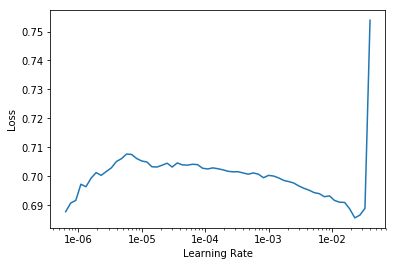

In [15]:
my_learner.lr_find()
my_learner.recorder.plot()


In [842]:
my_learner.fit_one_cycle(5, max_lr = 1e-03, wd = 0.01)
#my_learner.fit_one_cycle(3, max_lr=slice(None, 1e-03, 1e-02), wd = 0.1)


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.1117,  0.0819],
        [-0.1096,  0.0110],
        [-0.0771,  0.0614],
        [-0.1155,  0.0762]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.0940,  0.0762],
        [-0.0892,  0.0438],
        [-0.0908,  0.0404],
        [-0.1261,  0.0505]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: 


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.0020,  0.0361],
        [-0.0385,  0.0175],
        [-0.0337,  0.0357],
        [ 0.0114,  0.0226]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.0008,  0.0243],
        [ 0.0249,  0.0279],
        [ 0.0270,  0.0381],
        [-0.0111,  0.0478]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: 

End: tensor([[ 0.1241, -0.0560],
        [ 0.0300,  0.0217],
        [ 0.0789, -0.0025],
        [ 0.0743, -0.0038]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.0461,  0.0287],
        [ 0.0410,  0.0111],
        [ 0.1135, -0.0323],
        [ 0.0638,  0.0227]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.0679, -0.0100],
        [ 0.0613,  0.0081],
        [ 0.0870,  0.0361],
        [ 0.0799,  0.0301]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.0393,  0.0858],
        [ 0.0104,  0.0580],
        [-0.0279,  0.0701],
        [ 0.0099,  0.0337]], device='cuda:0')

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.0578,  0.0399],
        [ 0.0175,  0.0751],
        [-0.0415,  0.0568],
        [-0.0453,  0.0858]], device='cuda:0')

Input torch.Size([28, 468, 56])
Transposed: torch.Size([28, 56, 468])
Conv1: torch.Size([28, 56, 459])
Maxpool: torch.Size([28, 56, 153])
Linear1 torch.Size([28, 56, 1])
Reshape torch.Size([28, 56])
End: torch.Size([28, 2])
End: tensor([[-0.0273,  0.0732],
        [-0.0450,  0.0


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.0765,  0.0201],
        [-0.0862,  0.0633],
        [ 0.1572,  0.0109],
        [ 0.0348,  0.0547]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.1251, -0.0062],
        [-0.0132,  0.0388],
        [-0.0362,  0.0137],
        [-0.1112,  0.0993]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: 


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.3692,  0.2400],
        [-0.1183,  0.0863],
        [ 0.2139, -0.0638],
        [-0.0912,  0.1399]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.2335,  0.1593],
        [ 0.2471, -0.0787],
        [-0.4783,  0.2490],
        [-0.2864,  0.1647]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: 


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.0569, -0.0447],
        [ 0.3539, -0.1288],
        [ 0.2960, -0.0992],
        [-0.0933,  0.1114]], device='cuda:0')

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.4110, -0.1571],
        [ 0.2187, -0.0312],
        [ 0.3794, -0.1352],
        [ 0.4766, -0.1820]], device='cuda:0')

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.0703,  0.1094],
        [ 0.2843, -0.0


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.3064, -0.1179],
        [ 0.2207, -0.0899],
        [-0.3602,  0.2925],
        [ 0.1278, -0.0876]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.2698, -0.1163],
        [ 0.4978, -0.2822],
        [ 0.0534, -0.0153],
        [ 0.8793, -0.5195]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: 

End: tensor([[-0.0293,  0.2037],
        [ 0.0095,  0.0367],
        [-0.7557,  0.6387],
        [-0.2829,  0.1838]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.3448, -0.2217],
        [-0.8825,  0.7945],
        [-1.3050,  0.9367],
        [ 0.0656,  0.0504]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.6684, -0.3453],
        [ 1.0073, -0.5618],
        [-0.7564,  0.5559],
        [ 0.6237, -0.3689]], device='cuda:0', grad_fn=<SliceBackward>)

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])


Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.8564, -0.4390],
        [ 0.2065, -0.0053],
        [ 0.7564, -0.3884],
        [ 0.1826, -0.1281]], device='cuda:0')

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[ 0.0981,  0.0366],
        [-0.2432,  0.3402],
        [ 0.9725, -0.5206],
        [ 0.6517, -0.3473]], device='cuda:0')

Input torch.Size([32, 468, 56])
Transposed: torch.Size([32, 56, 468])
Conv1: torch.Size([32, 56, 459])
Maxpool: torch.Size([32, 56, 153])
Linear1 torch.Size([32, 56, 1])
Reshape torch.Size([32, 56])
End: torch.Size([32, 2])
End: tensor([[-0.6124,  0.5873],
        [ 0.5802, -0.2

Exception ignored in: <function _releaseLock at 0x7f3c727dee18>
Traceback (most recent call last):
  File "/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/logging/__init__.py", line 221, in _releaseLock
    def _releaseLock():
KeyboardInterrupt


KeyboardInterrupt: 

In [23]:
stats() #stage 1

Correct: 0.689
AUC 0.785
MCC 0.427
AVP 0.797

Tn, fp, fn, tp
[[199  13]
 [115  85]]
TPR: 0.425
TNR: 0.939


### 2nd simple

In [346]:
X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))

train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
test_ds = tdatautils.TensorDataset(X_test,y_test)

In [419]:
#hingeloss
yph =np.where(yp == 0, -1, 1)
yph_val = np.where(yp_val == 0, -1, 1)
yph_test = np.where(yp_test == 0, -1, 1)

y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yph, yph_val, yph_test))


In [412]:
np.where(ypc== 0, -1, 1)

array([ 1, -1, -1,  1, ...,  1,  1,  1, -1])

In [614]:
#dfs[0]["Type"] = 0
#dfs[0]["Type"].iloc[0:181] = 1
#dfs[0]["Type"].iloc[181:192] = 2
#dfs[0]["Type"].iloc[192:330] = 3
#dfs[0]["Type"].iloc[330:468] = 4

In [ ]:
net_dropped = torch.nn.Sequential(
    torch.nn.Linear(1, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, N_HIDDEN),
    torch.nn.Dropout(0.5),  # drop 50% of the neuron
    torch.nn.ReLU(),
    torch.nn.Linear(N_HIDDEN, 1),
)

In [33]:
batch_size = 32
#secret_size = 401
n_hid = 20
drop_prob = 0
ks1 = 1
ks2 = 3
my_data_bunch = DataBunch.create(train_ds, valid_ds, bs=batch_size)
criterion = nn.CrossEntropyLoss()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        #Conv1
        self.conv_1 = nn.Conv1d(in_channels = 56, out_channels = n_hid, kernel_size = 10)
        self.max_1 = nn.MaxPool1d(kernel_size = 3)
        self.drop_1 = nn.Dropout(p = drop_prob)
        self.selu_1 = nn.SELU()
        
        #self.conv_2 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = 10)
        #self.max_2 = nn.MaxPool1d(kernel_size = 3)
        #self.drop_2 = nn.Dropout(p = drop_prob)
        #self.selu_2 = nn.SELU()
        
        #self.conv_3 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = 10)
        #self.max_3 = nn.MaxPool1d(kernel_size = 3)
        #self.drop_3 = nn.Dropout(p = drop_prob)
        #self.selu_3 = nn.SELU()
        
        self.linear_4 = nn.Linear(in_features = 153, out_features = 1)
        self.selu_4 = nn.SELU()
        
        self.linear_last = nn.Linear(in_features = n_hid, out_features = 2)
        self.logsoft_last = nn.LogSoftmax()

    def forward(self, x):
        bs0 = x.shape[0]
        print("\nInput", x.shape)
        x = x.transpose(1, 2)
        print("Transpose", x.shape)
        
        x = self.selu_1(self.drop_1(self.max_1(self.conv_1(x))))
        print("Conv", x.shape)
        
        #x = self.selu_2(self.drop_2(self.max_2(self.conv_2(x))))
        #print("Conv2", x.shape)
        
        #x = self.selu_3(self.drop_3(self.max_3(self.conv_3(x))))
        #print("Conv3", x.shape)
        
        x = self.linear_4(x)
        x = self.selu_4(x)
        print("Lin4", x.shape)
        
        x = x.reshape(bs0, n_hid)
        print("Reshape", x.shape)
        x = self.linear_last(x)
        print("Last", x.shape)
        x = self.logsoft_last(x)
        print("Logged", x.shape)
        return x

#print(net)  
#print( 'trainable params: {}'.format(count_model_params(net)) )
net = Model().cuda()

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=accuracy)
#my_learner.fit_one_cycle(3, 1e-03)


In [34]:
my_learner.fit_one_cycle(10, 5e-3, wd = 0.01)
#my_learner.fit_one_cycle(3, max_lr=slice(None, 1e-03, 5e-02), wd = 0.01)


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])


/home/maghoi/.conda/envs/fastai_py37/lib/python3.7/site-packages/ipykernel_launcher.py:58: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La

Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([28, 468, 56])
Transpose torch.Size([28, 56, 468])
Conv torch.Size([28, 20, 153])
Lin4 torch.Size([28, 20, 1])
Reshape torch.Size([28, 20])
Last torch.Size([28, 2])
Logged torch.Size([28, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La


Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
Last torch.Size([32, 2])
Logged torch.Size([32, 2])

Input torch.Size([32, 468, 56])
Transpose torch.Size([32, 56, 468])
Conv torch.Size([32, 20, 153])
Lin4 torch.Size([32, 20, 1])
Reshape torch.Size([32, 20])
La

In [35]:
stats()

Correct: 0.648
AUC 0.78
MCC 0.36
AVP 0.807

Tn, fp, fn, tp
[[202  10]
 [135  65]]
TPR: 0.325
TNR: 0.953


### complex?

In [1027]:
#Upsampled dataset
#X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
#y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))

#Orig dataset
X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(X0, X0_val, X0_test))
y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(y0, y0_val, y0_test))

train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
#valid_ds = tdatautils.TensorDataset(X_test,y_test)
test_ds = tdatautils.TensorDataset(X_test,y_test)

In [1003]:
valid_ds.tensors[1].shape, test_ds.tensors[1].shape

(torch.Size([412]), torch.Size([210]))

In [ ]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0.5, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

generate = get_truncated_normal(mean=0.5, sd=2, low=0, upp=1)
w1 = generate.rvs(320)
w2 = generate.rvs(320)

m1 = torch.from_numpy(np.append(w1,w2)).to(torch.float32).cuda()
m2 = torch.from_numpy(np.append(w2,w1)).to(torch.float32).cuda()

### Random projector from gaussian distribution

In [ ]:
#Create pre-set gaussian noise vector
w1 = np.random.normal(size = (16,n_hid)).astype(np.float32)
w2 = np.random.normal(size = (16,n_hid)).astype(np.float32)

transformer = Normalizer().fit(w1)
w1 = transformer.transform(w1)
w1 = w1.reshape(320)
w1 = np.vstack([w1]*32)

transformer = Normalizer().fit(w2)
w2 = transformer.transform(w2)
w2 = w2.reshape(320)
w2 = np.vstack([w2]*32)

m1 = torch.from_numpy(np.append(w1,w2)).view(32,640).cuda()
m2 = torch.from_numpy(np.append(w2,w1)).view(32,640).cuda()

In [ ]:
pd.DataFrame(m1[0]).describe()

### Random projector from 0-1 norm distribution

In [843]:
from scipy.stats import truncnorm

def get_truncated_normal(mean=0.5, sd=1, low=0, upp=10):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd)

generate = get_truncated_normal(mean=0.5, sd=2, low=0, upp=1)
w1 = generate.rvs(320).astype(np.float32)
w2 = generate.rvs(320).astype(np.float32)
w1 = np.vstack([w1]*32)
w2 = np.vstack([w2]*32)

m1 = torch.from_numpy(np.append(w1,w2)).view(32,640).cuda()
m2 = torch.from_numpy(np.append(w2,w1)).view(32,640).cuda()

In [844]:
X, X_val, X_test = map(lambda x: to_torch_data(x,float,torch.float32),(Xp, Xp_val, Xp_test))
y, y_val, y_test = map(lambda x: to_torch_data(x,int,torch.int64),(yp, yp_val, yp_test))

train_ds = tdatautils.TensorDataset(X,y)
valid_ds = tdatautils.TensorDataset(X_val,y_val)
#valid_ds = tdatautils.TensorDataset(X_test,y_test)
test_ds = tdatautils.TensorDataset(X_test,y_test)

### Gussian noise

In [1004]:
#Gaussian noise
# Final maxpool layer default gives size 32 * 20 = 640. With additional maxpool = 16 * 20 = 320.
bs = batch_size
n_hid = int(n_hid/2)

#bs 32, N-hid 20 = 640
# N-hid based on number of features

#Create pre-set gaussian noise vector
w1 = np.random.normal(size = (int(bs/2), n_hid)).astype(np.float32)
w2 = np.random.normal(size = (int(bs/2), n_hid)).astype(np.float32)

transformer = Normalizer().fit(w1)
w1 = transformer.transform(w1)
w1 = w1.reshape(int(bs/2) * n_hid)
w1 = np.vstack([w1] * int(bs))

transformer = Normalizer().fit(w2)
w2 = transformer.transform(w2)
w2 = w2.reshape(int(bs/2) * n_hid)
w2 = np.vstack([w2] * int(bs))

m1 = torch.from_numpy(np.append(w1,w2)).view(bs, int(bs)*n_hid).cuda()
m2 = torch.from_numpy(np.append(w2,w1)).view(bs, int(bs)*n_hid).cuda()

In [1005]:
w1.shape

(32, 448)

In [1006]:
m1.shape

torch.Size([32, 896])

In [1007]:
torch.cuda.manual_seed_all(42)

In [1032]:
batch_size = 32
#secret_size = 401
in_channel = 56
n_hid = 56
drop_prob = 0.1
ks1 = 11
pad1 = int((ks1) / 2)

ks2 = 3
epochs = 0
ps = True
my_data_bunch = DataBunch.create(train_ds, valid_ds, bs=batch_size)
#criterion = nn.CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        
        #Pad
        self.m_pad = nn.ConstantPad1d((160), 0)
        self.t_pad = nn.ConstantPad1d((118), 0)
        #self.p_pad = nn.ConstantPad1d((112, 113), 0)
        
        #Conv1
        self.m_conv_1 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.m_norm_1 = nn.BatchNorm1d(n_hid)
        self.m_max_1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.m_drop_1 = nn.Dropout(p = drop_prob)
        self.m_ReLU_1 = nn.ReLU()

        self.t_conv_1 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.t_norm_1 = nn.BatchNorm1d(n_hid)
        self.t_max_1 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.t_drop_1 = nn.Dropout(p = drop_prob)
        self.t_ReLU_1 = nn.ReLU()

        #Conv2
        self.m_conv_2 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.m_norm_2 = nn.BatchNorm1d(n_hid)
        self.m_max_2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.m_drop_2 = nn.Dropout(p = drop_prob)
        self.m_ReLU_2 = nn.ReLU()
        self.m_norm_22 = nn.BatchNorm1d(n_hid)
        self.m_ReLU_22 = nn.ReLU()

        self.t_conv_2 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.t_norm_2 = nn.BatchNorm1d(n_hid)
        self.t_max_2 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.t_drop_2 = nn.Dropout(p = drop_prob)
        self.t_ReLU_2 = nn.ReLU()


        #Conv3
        self.m_conv_3 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.m_norm_3 = nn.BatchNorm1d(n_hid)
        self.m_max_3 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.m_drop_3 = nn.Dropout(p = drop_prob)
        self.m_ReLU_3 = nn.ReLU()

        self.t_conv_3 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.t_norm_3 = nn.BatchNorm1d(n_hid)
        self.t_max_3 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.t_drop_3 = nn.Dropout(p = drop_prob)
        self.t_ReLU_3 = nn.ReLU()

        #Conv4
        self.m_conv_4 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.m_norm_4 = nn.BatchNorm1d(n_hid)
        self.m_max_4 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.m_drop_4 = nn.Dropout(p = drop_prob)
        self.m_ReLU_4 = nn.ReLU()

        self.t_conv_4 = nn.Conv1d(in_channels = n_hid, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.t_norm_4 = nn.BatchNorm1d(n_hid)
        self.t_max_4 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.t_drop_4 = nn.Dropout(p = drop_prob)
        self.t_ReLU_4 = nn.ReLU()
        
        #Conv5
        self.m_conv_5 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.m_norm_5 = nn.BatchNorm1d(n_hid)
        self.m_max_5 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.m_drop_5 = nn.Dropout(p = drop_prob)
        self.m_ReLU_5 = nn.ReLU()

        self.t_conv_5 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        self.t_norm_5 = nn.BatchNorm1d(n_hid)
        self.t_max_5 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        self.t_drop_5 = nn.Dropout(p = drop_prob)
        self.t_ReLU_5 = nn.ReLU()

        #Conv6
        #self.m_conv_6 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        #self.m_norm_6 = nn.BatchNorm1d(n_hid)
        #self.m_max_6 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        #self.m_drop_6 = nn.Dropout(p = drop_prob)
        #self.m_ReLU_6 = nn.ReLU()

        #self.t_conv_6 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        #self.t_norm_6 = nn.BatchNorm1d(n_hid)
        #self.t_max_6 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        #self.t_drop_6 = nn.Dropout(p = drop_prob)
        #self.t_ReLU_6 = nn.ReLU()
        
        #Conv7
        #self.m_conv_7 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        #self.m_norm_7 = nn.BatchNorm1d(n_hid)
        #self.m_max_7 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        #self.m_drop_7 = nn.Dropout(p = drop_prob)
        #self.m_ReLU_7 = nn.ReLU()

        #self.t_conv_7 = nn.Conv1d(in_channels = in_channel, out_channels = n_hid, kernel_size = ks1, padding = pad1)
        #self.t_norm_7 = nn.BatchNorm1d(n_hid)
        #self.t_max_7 = nn.MaxPool1d(kernel_size = 2, stride = 2)
        #self.t_drop_7 = nn.Dropout(p = drop_prob)
        #self.t_ReLU_7 = nn.ReLU()

        #Random projection module
        self.mrp_Linear = nn.Linear(in_features = (16)*n_hid, out_features = 16*n_hid)
        self.mrp_norm = nn.BatchNorm1d(16*n_hid)
        self.mrp_ReLU = nn.ReLU()
        
        self.trp_Linear = nn.Linear(in_features = (16)*n_hid, out_features = 16*n_hid)
        self.trp_norm = nn.BatchNorm1d(16*n_hid)
        self.trp_ReLU = nn.ReLU()
        
        #self.prp_Linear = nn.Linear(in_features = 32*n_hid, out_features = 32*n_hid)
        #self.prp_norm = nn.BatchNorm1d(32*n_hid)
        #self.prp_ReLU = nn.ReLU()
        
        #Linear last layer
        self.a_linear = nn.Linear(in_features = 16*n_hid, out_features = 2)
        self.a_sigmoid = nn.Sigmoid()

    def forward(self, x):
        global ps
        bs0 = x.shape[0]
        x = x[:, :, :]
        #x = x[:, :, :]
        
        if ps: print("\nInput", x.shape)
        x = x.transpose(1, 2)
        if ps: print("Transpose", x.shape)
        
        mhcp = x[:, :, 0:192]
        tcr = x[:, :, 192:]
        pep = x[:, :, 181:192]
        pep0 = pep
        #tcr = torch.cat((tcr, pep), dim = 2)
        if ps: print("Shapes", mhcp.shape, tcr.shape, pep.shape)

        mhcp0 = self.m_pad(mhcp)
        tcr0 = self.t_pad(tcr)
        #pep0 = self.p_pad(pep)
        if ps: print("Padded", mhcp0.shape, tcr0.shape, pep0.shape)
        
        mhcp = self.m_max_1(self.m_drop_1(self.m_ReLU_1(self.m_norm_1(self.m_conv_1(mhcp0)))))
        tcr = self.t_max_1(self.t_drop_1(self.t_ReLU_1(self.t_norm_1(self.t_conv_1(tcr0)))))
        #pep = self.p_max_1)(self.p_drop_1(self.p_ReLU_1(self.p_norm_1(self.p_conv_1(pep0)))))
        if ps: print("Conv1", mhcp.shape, tcr.shape, pep.shape)

        mhcp = self.m_max_2(mhcp + self.m_drop_2(self.m_ReLU_2(self.m_norm_2(self.m_conv_2(mhcp)))))
        tcr = self.t_max_2(tcr + self.t_drop_2(self.t_ReLU_2(self.t_norm_2(self.t_conv_2(tcr)))))
        #pep = self.p_max_2)(self.p_drop_2(self.p_ReLU_2(self.p_norm_2(self.p_conv_2(pep)))))
        if ps: print("Conv2", mhcp.shape, tcr.shape,pep.shape)

        mhcp = self.m_max_3(mhcp + self.m_drop_3(self.m_ReLU_3(self.m_norm_3(self.m_conv_3(mhcp)))))
        tcr = self.t_max_3(tcr + self.t_drop_3(self.t_ReLU_3(self.t_norm_3(self.t_conv_3(tcr)))))
        #pep = self.p_max_3)(self.p_drop_3(self.p_ReLU_3(self.p_norm_3(self.p_conv_3(pep)))))
        if ps: print("Conv3", mhcp.shape, tcr.shape, pep.shape)

        mhcp = self.m_max_4(mhcp + self.m_drop_4(self.m_ReLU_4(self.m_norm_4(self.m_conv_4(mhcp)))))
        tcr = self.t_max_4(tcr + self.t_drop_4(self.t_ReLU_4(self.t_norm_4(self.t_conv_4(tcr)))))
        #pep = self.p_max_4)(self.p_drop_4(self.p_ReLU_4(self.p_norm_4(self.p_conv_4(pep)))))
        if ps: print("Conv4", mhcp.shape, tcr.shape, pep.shape)
            
        mhcp = self.m_max_5(mhcp + self.m_drop_5(self.m_ReLU_5(self.m_norm_5(self.m_conv_5(mhcp)))))
        tcr = self.t_max_5(tcr + self.t_drop_5(self.t_ReLU_5(self.t_norm_5(self.t_conv_5(tcr)))))
        #pep = self.p_max_5(self.p_drop_5(self.p_ReLU_5(self.p_norm_5(self.p_conv_5(pep)))))
        if ps: print("Conv5", mhcp.shape, tcr.shape, pep.shape)
            
        #mhcp = mhcp + self.m_drop_6(self.m_ReLU_6(self.m_norm_6(self.m_conv_6(mhcp))))
        #tcr = tcr + self.t_drop_6(self.t_ReLU_6(self.t_norm_6(self.t_conv_6(tcr))))
        #pep = self.p_max_6)(self.p_drop_6(self.p_ReLU_6(self.p_norm_6(self.p_conv_6(pep)))))
        #if ps: print("Conv4", mhcp.shape, tcr.shape, pep.shape)
            
        #mhcp = mhcp + self.m_drop_7(self.m_ReLU_7(self.m_norm_7(self.m_conv_7(mhcp))))
        #tcr = tcr + self.t_drop_7(self.t_ReLU_7(self.t_norm_7(self.t_conv_7(tcr))))
        #pep = self.p_max_7)(self.p_drop_7(self.p_ReLU_7(self.p_norm_7(self.p_conv_7(pep)))))
        #if ps: print("Conv4", mhcp.shape, tcr.shape, pep.shape)

        #Size = 512 / (# maxpools) * n_hid
        mhcp = mhcp.view(bs0, int(512/(2**5))*n_hid)
        tcr = tcr.view(bs0, int(512/(2**5))*n_hid)
        #pep = pep.view(bs0640)
        if ps: print("Views", mhcp.shape, tcr.shape, pep.shape)

        mhcp = mhcp + self.mrp_ReLU(self.mrp_norm(self.mrp_Linear(mhcp)))
        tcr = tcr + self.trp_ReLU(self.trp_norm(self.trp_Linear(tcr)))
        #pep = self.prp_ReLU(self.prp_norm(self.prp_Linear(pep)))
        if ps: print("Pre-rp", mhcp.shape, tcr.shape, pep.shape)
        
        #Random projection -> 640
        mhcp = mhcp * m1[0:bs0]
        tcr = tcr * m2[0:bs0]
        #pep = pep * m1[0:bs0]
        #if ps: print("RPed", mhcp.shape, tcr.shape, pep.shape)
        
        
        allparts = mhcp * tcr
        if ps: print("Allparts", allparts.shape)
        
        #Linear module
        allparts = self.a_linear(allparts)
        allparts = self.a_sigmoid(allparts)
        if ps: print("Last", allparts.shape)
        ps = False
        
        x = allparts
        #print(x[-1])
        return x

#print(net)  
#print( 'trainable params: {}'.format(count_model_params(net)) )
net = Model().cuda()

my_learner = Learner(my_data_bunch,
                     net,
                     opt_func=torch.optim.Adam,
                     loss_func=criterion, metrics=[accuracy],
                    wd = 0.01)
#opt_func=torch.optim.Adam
#my_learner.fit_one_cycle(1, 1e-02, wd = 0.01)


In [1012]:
#my_learner.fit_one_cycle(1, 1e-2, wd = 0.1)
my_learner.fit_one_cycle(4, max_lr=slice(None, 5e-03, 5e-02), wd = 0.01)
epochs += 1

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


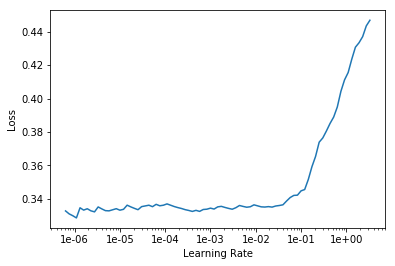

In [1011]:
my_learner.lr_find()
my_learner.recorder.plot()

In [1013]:
stats()

Correct: 0.869
AUC 0.85
MCC 0.742
AVP 0.889

Tn, fp, fn, tp
[[197  15]
 [ 39 161]]
TPR: 0.805
TNR: 0.929


In [1033]:
my_learner.load("Alldata87")

Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f3bbaf2d278>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f3bbaf2d940>;

Test: None, model=Model(
  (m_pad): ConstantPad1d(padding=(160, 160), value=0)
  (t_pad): ConstantPad1d(padding=(118, 118), value=0)
  (m_conv_1): Conv1d(56, 56, kernel_size=(11,), stride=(1,), padding=(5,))
  (m_norm_1): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (m_max_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (m_drop_1): Dropout(p=0.1)
  (m_ReLU_1): ReLU()
  (t_conv_1): Conv1d(56, 56, kernel_size=(11,), stride=(1,), padding=(5,))
  (t_norm_1): BatchNorm1d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_max_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_drop_1): Dropout(p=0.1)
  (t_ReLU_1): ReLU()
  (m_conv_2): Conv1d(56, 56, kernel_size=(11,), stride=(1,), padding=(5,))
  (

In [1034]:
stats()

Correct: 0.91
AUC 0.858
MCC 0.706
AVP 0.755

Tn, fp, fn, tp
[[197  15]
 [  8  36]]
TPR: 0.818
TNR: 0.929


In [1029]:
my_data_bunch = DataBunch.create(train_ds, valid_ds, bs=batch_size)

In [954]:
X.shape

torch.Size([1811, 468, 56])

In [872]:
stats()

Correct: 0.869
AUC 0.827
MCC 0.742
AVP 0.851

Tn, fp, fn, tp
[[197  15]
 [ 39 161]]
TPR: 0.805
TNR: 0.929


In [730]:
np.save("models/Resnetidea_aminoonly_085_m1.npy", m1)

In [711]:
my_learner.load("Resnetidea_aminoonly_085")
m1 = np.load("models/Resnetidea_aminoonly_085_m1.npy")
m2 = np.load("models/Resnetidea_aminoonly_085_m2.npy")


Learner(data=DataBunch;

Train: <torch.utils.data.dataset.TensorDataset object at 0x7f3bbb3612e8>;

Valid: <torch.utils.data.dataset.TensorDataset object at 0x7f3bb8488198>;

Test: None, model=Model(
  (m_pad): ConstantPad1d(padding=(160, 160), value=0)
  (t_pad): ConstantPad1d(padding=(118, 118), value=0)
  (m_conv_1): Conv1d(20, 20, kernel_size=(11,), stride=(1,), padding=(5,))
  (m_norm_1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (m_max_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (m_drop_1): Dropout(p=0.1)
  (m_ReLU_1): ReLU()
  (t_conv_1): Conv1d(20, 20, kernel_size=(11,), stride=(1,), padding=(5,))
  (t_norm_1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (t_max_1): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (t_drop_1): Dropout(p=0.1)
  (t_ReLU_1): ReLU()
  (m_conv_2): Conv1d(20, 20, kernel_size=(11,), stride=(1,), padding=(5,))
  (

In [468]:
a = np.array(range(1,11))
b = np.array(range(1,11))
output = np.zeros((10,10))
output.shape

def vectors_to_matrix(a, b):
    dims = a.shape
    tensor = np.zeros(shape = (dims))
    matrix = np.zeros(shape = (len(a), len(b)))
    for i in range(0, len(dims[0])):
        for i in range(len(a)):
            matrix[i] = a[i] * b
        tensor[i] = matrix
    return matrix   


### Analysis

In [20]:
def stats():
    #Get raw predictions
    preds = my_learner.get_preds()
    outputs = preds[0]
    targets = preds[1]

    #Find highest multi-class prediction (yes, this is wrong ...)
    yhat = []

    for i in range(len(outputs)):
        pred = outputs[i].tolist()
        pred = pred.index(max(pred))
        yhat.append(pred)

    #Pairwise comparison
    yhat = np.array(yhat)
    y_true = np.array(targets)
    y_scores = outputs[:, 1]
    y_scores_binary = np.where(y_scores > 0.5, 1, 0)

    correct = yhat == y_true
    auc = roc_auc_score(y_true, y_scores)
    mcc = matthews_corrcoef(y_true, y_scores_binary)
    avp = average_precision_score(y_true, y_scores)

    print("Correct:", round(sum(correct) / len(targets), 3))
    print("AUC", round(auc, 3))
    print("MCC", round(mcc, 3))
    print("AVP", round(avp, 3))

    print("\nTn, fp, fn, tp")
    print(metrics.confusion_matrix(y_true, yhat))
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, yhat).ravel()
    tpr = (tp / (tp+fn))
    tnr = (tn / (tn+fp))
    print("TPR:", round(tpr, 3))
    print("TNR:", round(tnr, 3))

